# Feature Selection & Random Forest

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score


print("Done")

Done


In [15]:
pd.set_option('display.max_columns', None)
kepler1 = pd.read_csv("/content/drive/MyDrive/DJSCE_Datasets/Nova/cumulative.csv")
kepler = (kepler1
     .drop(['rowid', 'kepid'], axis='columns')
     .rename(columns={'koi_disposition': 'disposition', 'koi_pdisposition': 'predisposition'})
     .pipe(lambda df: df.assign(disposition=(df.disposition == 'CONFIRMED').astype(int), predisposition=(df.predisposition == 'CANDIDATE').astype(int)))
     .pipe(lambda df: df.loc[:, df.dtypes.values != np.dtype('O')])  # drop str columns
     .pipe(lambda df: df.loc[:, (df.isnull().sum(axis='rows') < 500).where(lambda v: v).dropna().index.values])  # drop columns with greater than 500 null values
     .dropna()
)

kepler_X = kepler.iloc[:, 1:]
kepler_y = kepler.iloc[:, 0]

kepler.head()


,disposition,predisposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,1,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,93.59,29.45,-16.65,35.8,1.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,1,1,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,9.11,2.87,-1.62,25.8,2.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,0,0,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,39.30,31.04,-10.49,76.3,1.0,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,0,0,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,891.96,668.95,-230.35,505.6,1.0,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,1,1,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,926.16,874.33,-314.24,40.9,1.0,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [14]:
kepler1.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,q1_q17_dr25_tce,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,q1_q17_dr25_tce,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,q1_q17_dr25_tce,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


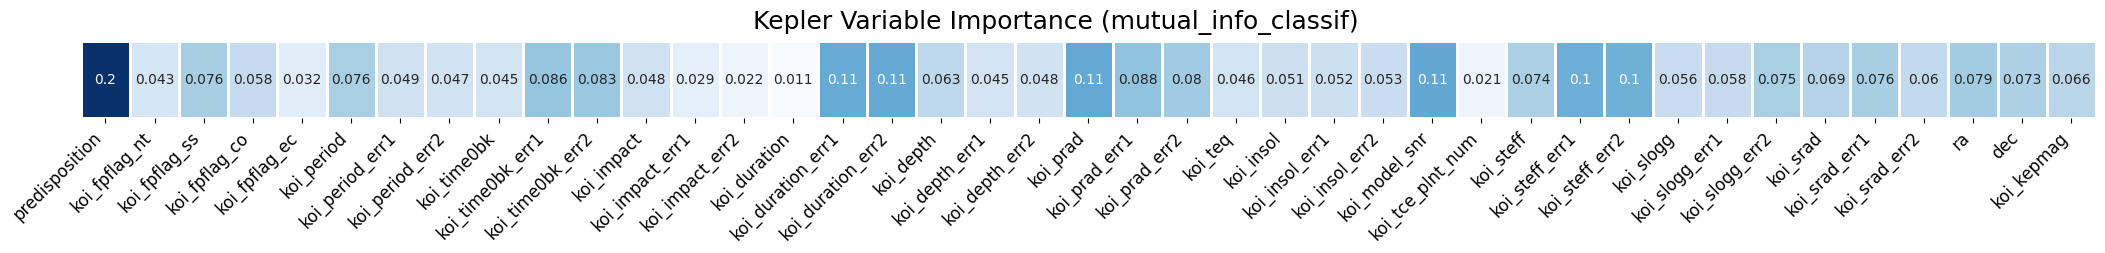

In [4]:
from sklearn.feature_selection import mutual_info_classif
kepler_mutual_information = mutual_info_classif(kepler_X, kepler_y)

plt.subplots(1, figsize=(26, 1))
sns.heatmap(kepler_mutual_information[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(kepler.columns[1:], rotation=45, ha='right', fontsize=12)
plt.suptitle("Kepler Variable Importance (mutual_info_classif)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)
pass

In [8]:
trans = GenericUnivariateSelect(score_func=mutual_info_classif, mode='percentile', param=50)
kepler_X_trans = trans.fit_transform(kepler_X, kepler_y)

In [9]:
kepler_X.shape #fed 40 features in X,

(8744, 41)

In [11]:
kepler_X_trans.shape # GenericUnivariate select only retaied 20 features

(8744, 20)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(kepler_X_trans, kepler_y, train_size=0.7, shuffle=True, random_state=1)


In [37]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)


RandomForestClassifier()

In [38]:
y_pred = clf.predict(X_test)


In [39]:
y_pred

array([0, 0, 1, ..., 0, 0, 0])

In [40]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8944359756097561

Confusion Matrix:
 [[1803  145]
 [ 132  544]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1948
           1       0.79      0.80      0.80       676

    accuracy                           0.89      2624
   macro avg       0.86      0.87      0.86      2624
weighted avg       0.90      0.89      0.89      2624



# Experimentations


In [ ]:
#-----------JUST KEEDA KAANDI--------------

Try without GenericUnivariateSelect

In [33]:
X_train, X_test, y_train, y_test = train_test_split(kepler_X, kepler_y, train_size=0.7, shuffle=True, random_state=1)


In [34]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)


In [35]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8982469512195121

Confusion Matrix:
 [[1821  127]
 [ 140  536]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1948
           1       0.81      0.79      0.80       676

    accuracy                           0.90      2624
   macro avg       0.87      0.86      0.87      2624
weighted avg       0.90      0.90      0.90      2624



Just Visualizing the learning graph for RF


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1,  1.0,  5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    return plt

Accuracy: 0.8944359756097561

Confusion Matrix:
 [[1803  145]
 [ 132  544]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1948
           1       0.79      0.80      0.80       676

    accuracy                           0.89      2624
   macro avg       0.86      0.87      0.86      2624
weighted avg       0.90      0.89      0.89      2624



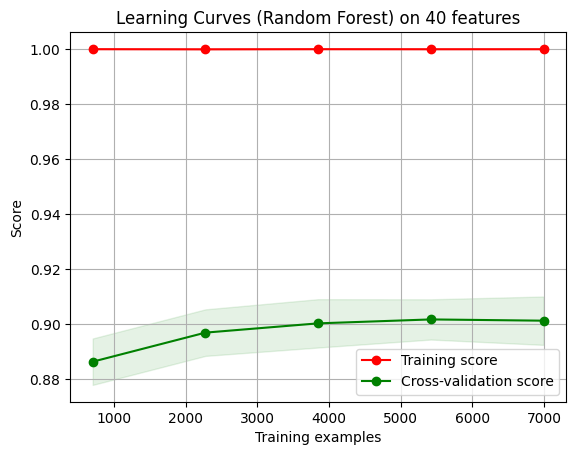

In [50]:
# Instantiate the classifier
rf = RandomForestClassifier()

# Define the title for the plot
title = "Learning Curves (Random Forest) on 40 features"

# Create the learning curve plot
plot_learning_curve(rf, title, kepler_X, kepler_y, cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=42))

plt.show()

Accuracy: 0.8944359756097561

Confusion Matrix:
 [[1803  145]
 [ 132  544]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1948
           1       0.79      0.80      0.80       676

    accuracy                           0.89      2624
   macro avg       0.86      0.87      0.86      2624
weighted avg       0.90      0.89      0.89      2624



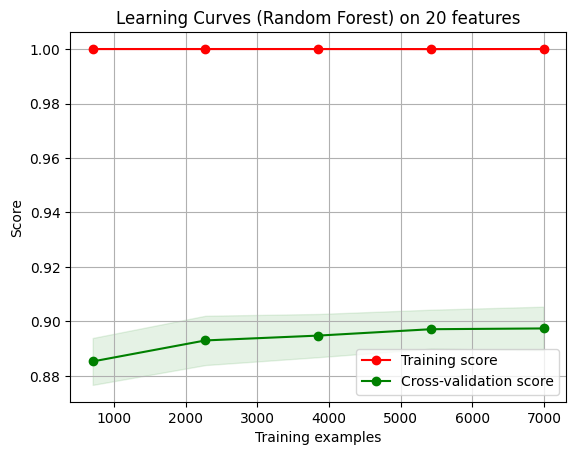

In [55]:
# Instantiate the classifier
rf1 = RandomForestClassifier()

# top 50% of Features based on percentile
trans = GenericUnivariateSelect(score_func=mutual_info_classif, mode='percentile', param=50)
kepler_X_trans = trans.fit_transform(kepler_X, kepler_y)

# Define the title for the plot
title = "Learning Curves (Random Forest) on 20 features"

# Create the learning curve plot
plot_learning_curve(rf1, title, kepler_X_trans, kepler_y, cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=42))

plt.show()

40 features performed better than the feature selected 20. Let's try something else.

In [52]:
trans = GenericUnivariateSelect(score_func=mutual_info_classif, mode='percentile', param=75)
kepler_X_trans = trans.fit_transform(kepler_X, kepler_y)

In [53]:
kepler_X_trans.shape

(8744, 30)

Accuracy: 0.8944359756097561

Confusion Matrix:
 [[1803  145]
 [ 132  544]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1948
           1       0.79      0.80      0.80       676

    accuracy                           0.89      2624
   macro avg       0.86      0.87      0.86      2624
weighted avg       0.90      0.89      0.89      2624



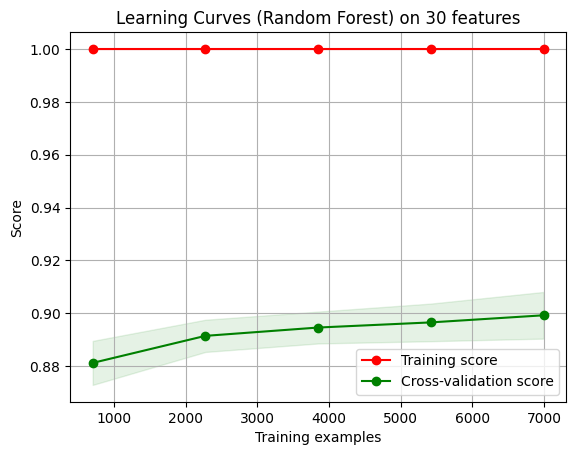

In [56]:
rf2 = RandomForestClassifier()

# top 75% of Features based on percentile
trans = GenericUnivariateSelect(score_func=mutual_info_classif, mode='percentile', param=75)
kepler_X_trans = trans.fit_transform(kepler_X, kepler_y)

# Define the title for the plot
title = "Learning Curves (Random Forest) on 30 features"

# Create the learning curve plot
plot_learning_curve(rf2, title, kepler_X_trans, kepler_y, cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=42))

plt.show()